In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Data exploration

## Load event log

In [3]:
log = pm4py.read_xes("../Full_BPI_Challenge_2019.xes")
# Filter events that occur before 2018
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])
log = log[log['time:timestamp'] >= '2018-01-01 00:00:00']

c:\Users\jsala\Documents\GitHub\MDS-PODS-Proj1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 251734/251734 [00:54<00:00, 4627.20it/s]


In [4]:
# Rename the spend area text column in the log to group all cases that don not belong to 'Sales' or 'Packaging' into the 'Other' category

log["case:Spend area text"] = log["case:Spend area text"].apply(
    lambda x: x if x in ["Sales", "Packaging"] else "Other"
)

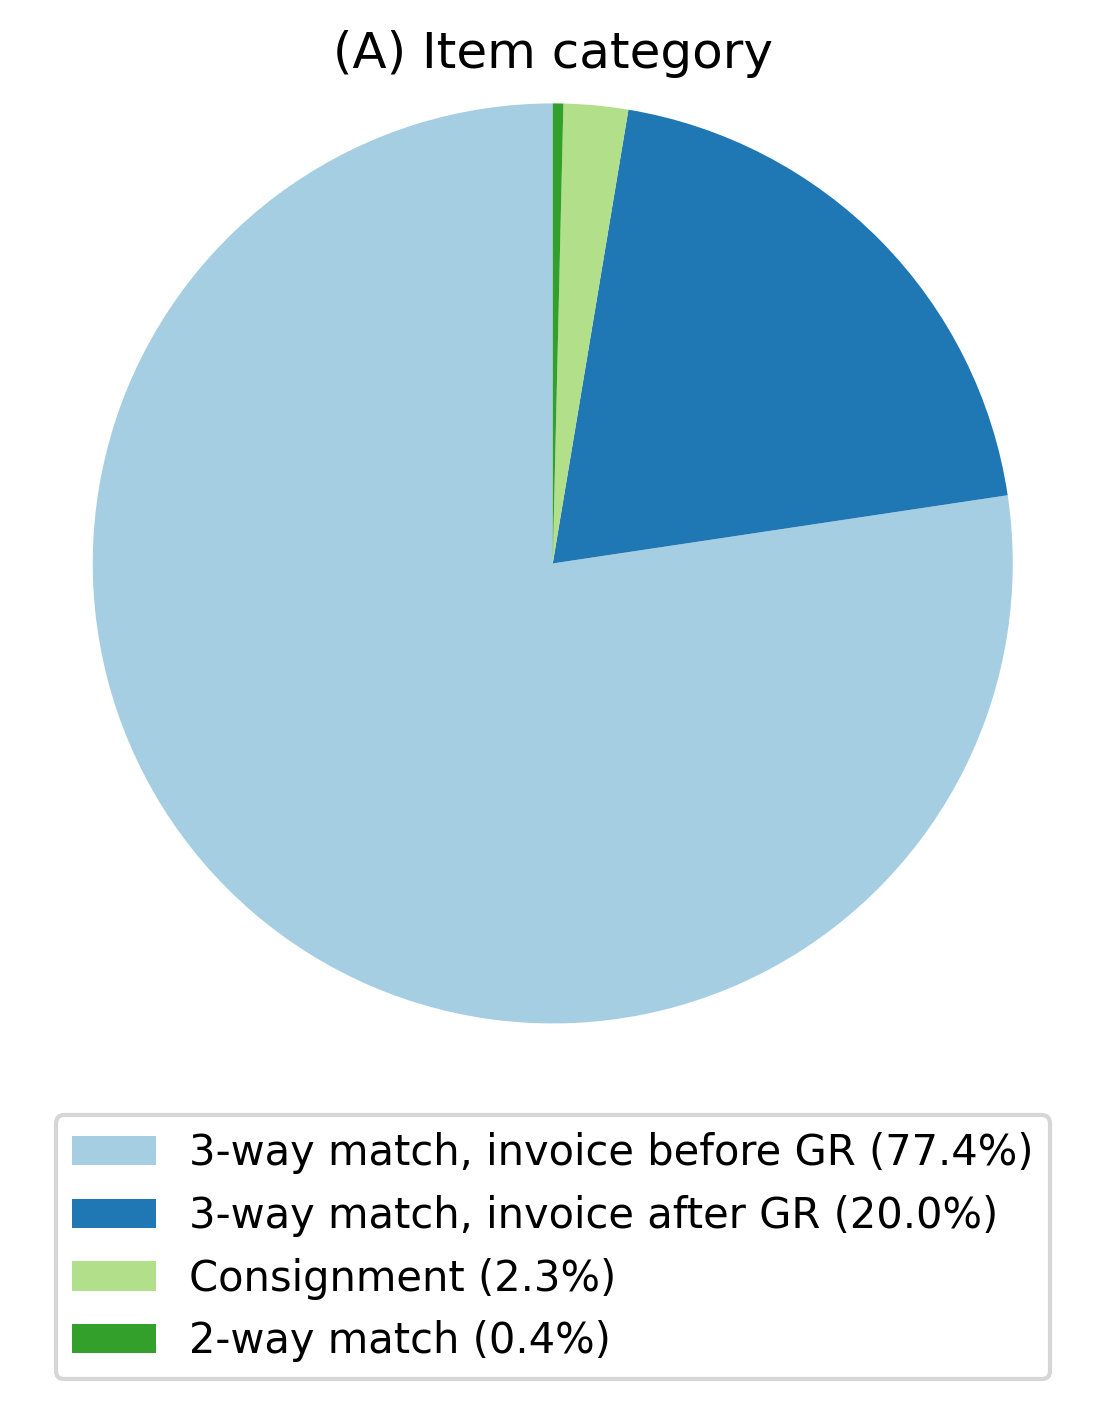

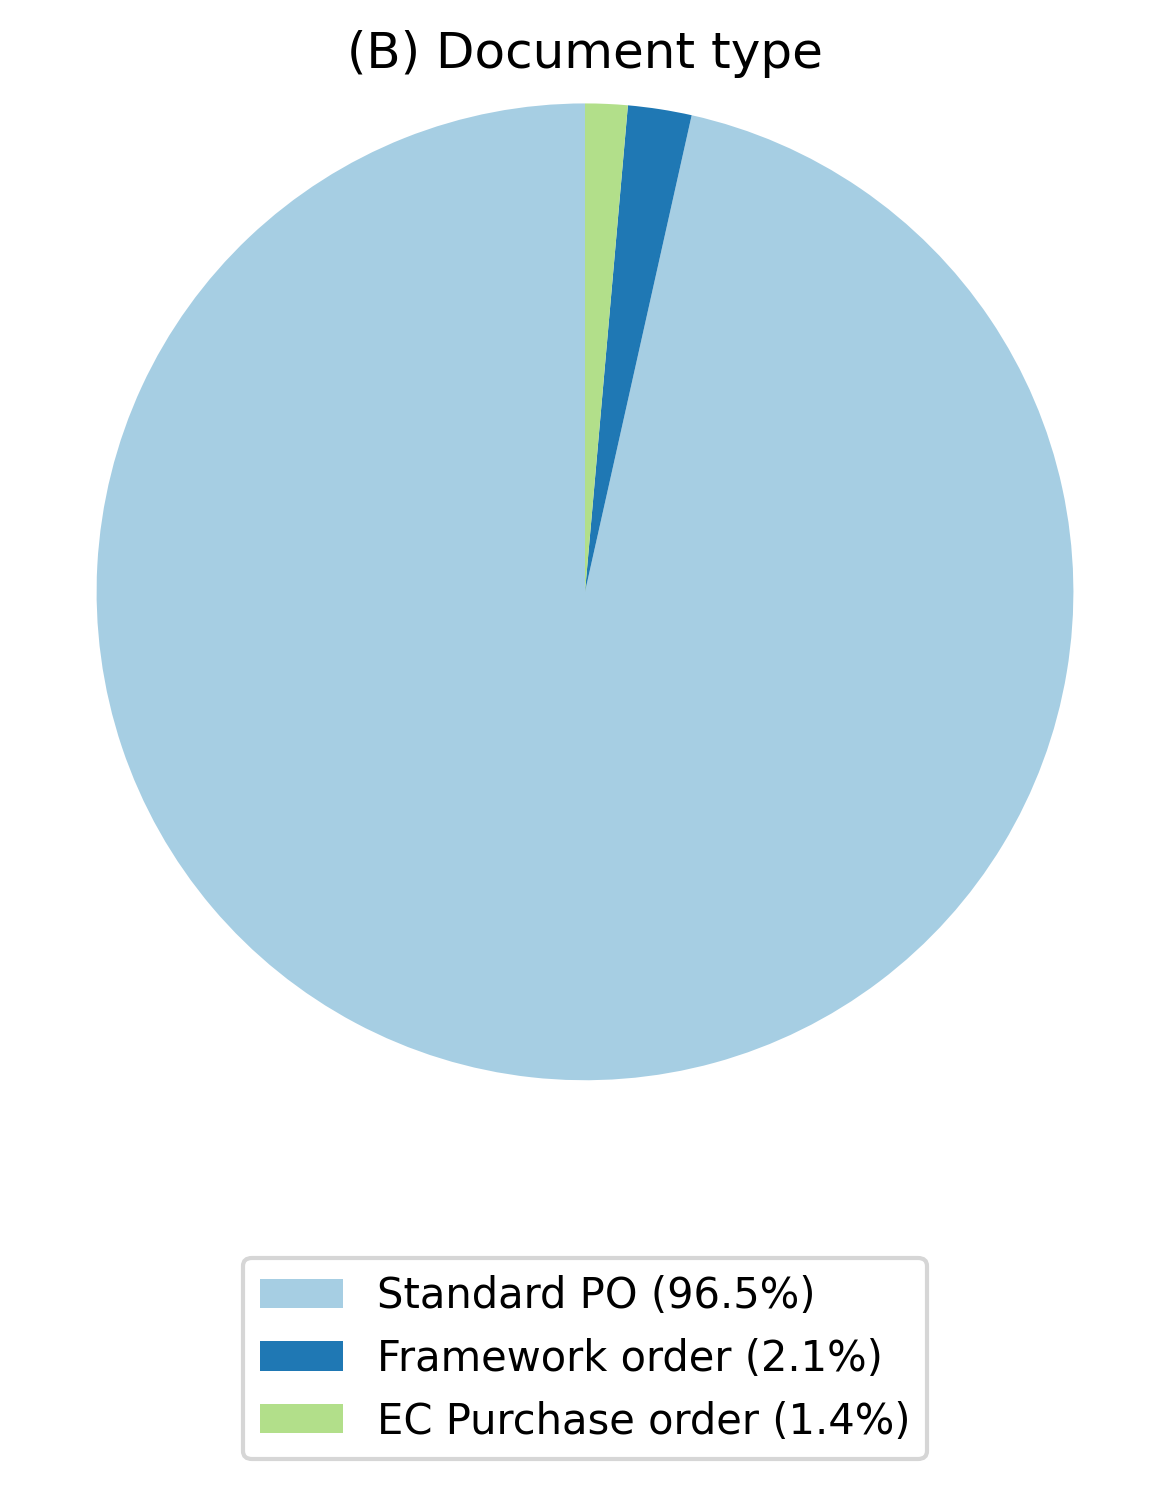

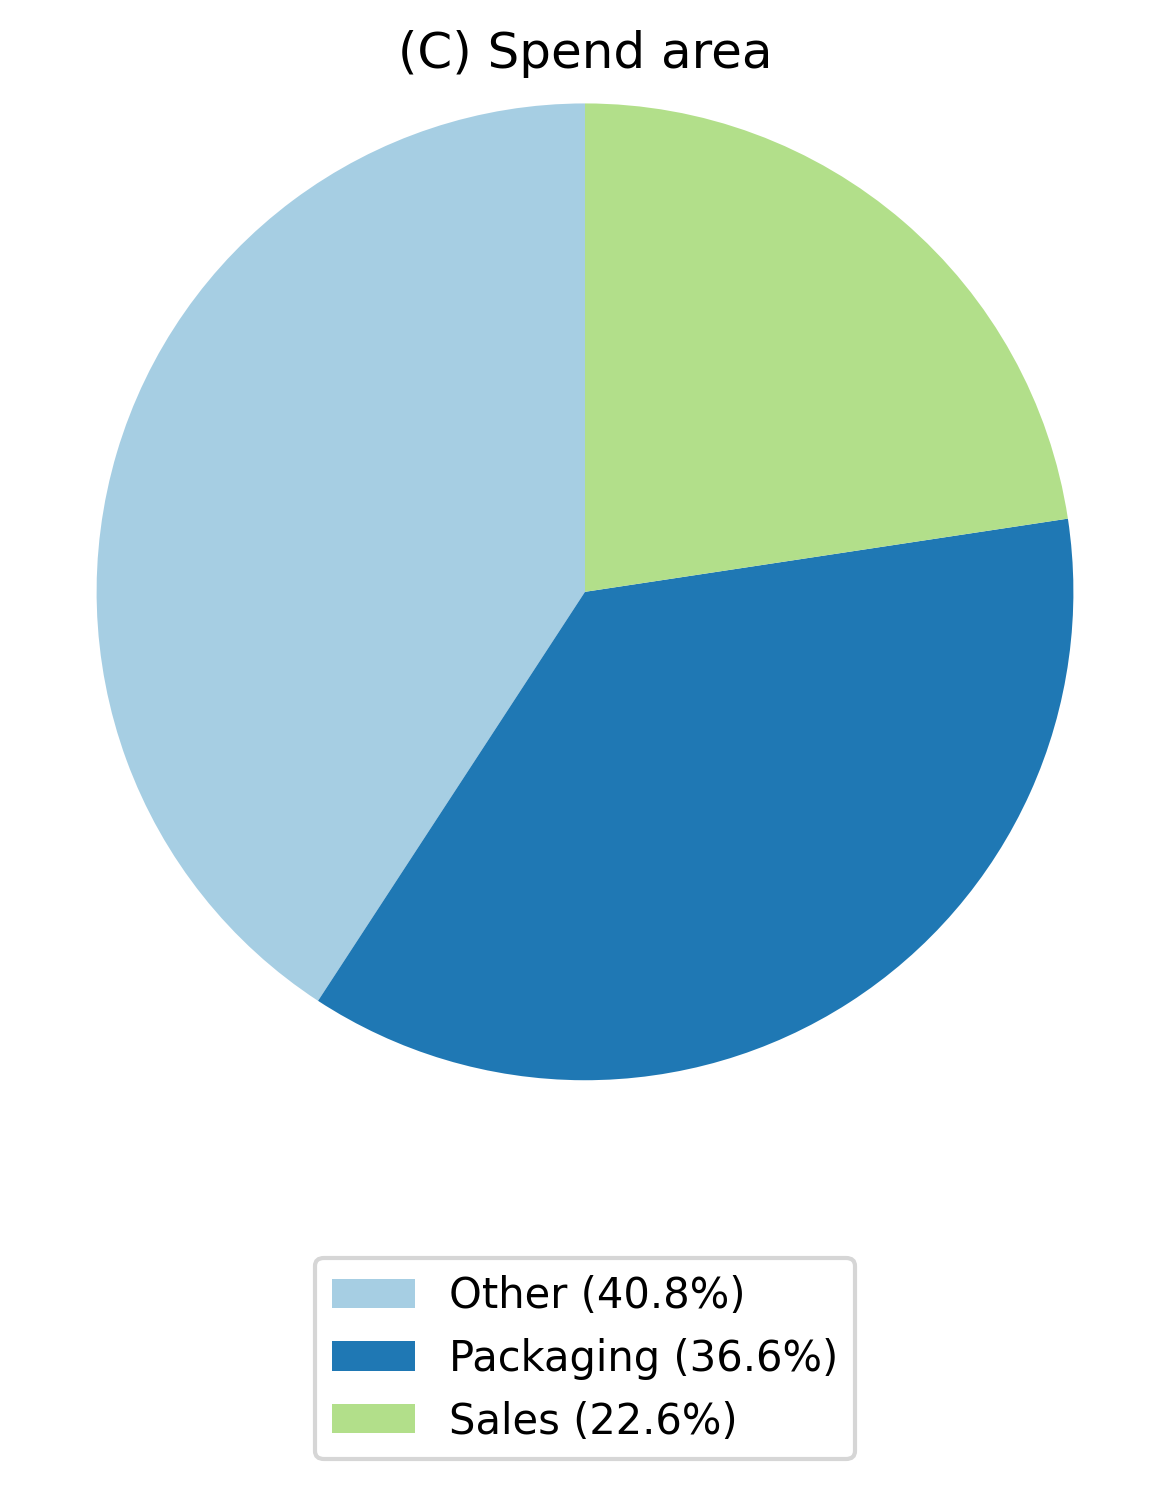

In [5]:
# Generate a pie chart of percentages for a given attribute from the event log

def plot_pie_chart(event_log, column_attribute, title, filename=None):
    event_log_df = pm4py.convert_to_dataframe(event_log)
    
    # Count the occurrences of each category in the specified column
    category_counts = event_log_df[column_attribute].value_counts()

    # Plot generation

    plt.figure(figsize=(4,5), dpi=300) 
    wedges, texts, autotexts = plt.pie(
        category_counts.values,
        startangle=90,
        colors=plt.cm.Paired.colors,
        autopct=lambda pct: "" ,
        radius=1.1
    )
    legend_labels = [f"{label} ({value:.1f}%)" for label, value in zip(category_counts.index, (category_counts.values / category_counts.values.sum()) * 100)]
    plt.legend(wedges, legend_labels, title='', loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=1 )
    plt.title(title, y=0.95)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')

    plt.show()

plot_pie_chart(log, "case:Item Category", "(A) Item category", filename="item_category_plot.png")
plot_pie_chart(log, "case:Document Type", "(B) Document type", filename="document_type_plot.png")
plot_pie_chart(log, "case:Spend area text", "(C) Spend area", filename="spend_area_plot.png")


## Filter event log by item category and document type

In [6]:
filtered_logs = {}
for item_category in log["case:Item Category"].unique():
    category_log = log[log["case:Item Category"] == item_category]
    for document_type in category_log["case:Document Type"].unique():
        category_df_by_document = category_log[
            category_log["case:Document Type"] == document_type
        ]
        
        filtered_logs[f"{item_category}_{document_type}"] = category_df_by_document


allowed_end_act = {
    "3-way match, invoice before GR_EC Purchase order": [
        "Clear Invoice",  #: 713,
        # "SRM: Transaction Completed",  #: 1,
        # "Record Invoice Receipt",  #: 45,
        # "Record Goods Receipt",  #: 39,
        # "Delete Purchase Order Item",  #: 4,
        # "SRM: In Transfer to Execution Syst.",  #: 4,
        # "Create Purchase Order Item",  #: 4,
        # "Cancel Invoice Receipt",  #: 3,
        # "Change Final Invoice Indicator",  #: 2,
        # "Remove Payment Block",  #: 5,
        # "SRM: Change was Transmitted",  #: 9,
    ],
    "3-way match, invoice before GR_Standard PO": [
        "Clear Invoice",  #: 171191,
        # "Record Invoice Receipt",  #: 21413,
        "Delete Purchase Order Item",  #: 7409,
        # "Cancel Invoice Receipt",  #: 1261,
        # "Change Quantity",  #: 406,
        # "Change Price",  #: 443,
        # "Record Goods Receipt",  #: 7288,
        # "Change Delivery Indicator",  #: 415,
        # "Block Purchase Order Item",  #: 167,
        # "Create Purchase Order Item",  #: 3714,
        # "Cancel Goods Receipt",  #: 209,
        # "Change Approval for Purchase Order",  #: 797,
        # "Remove Payment Block",  #: 5136,
        # "Change Currency",  #: 1,
        # "Reactivate Purchase Order Item",  #: 11,
        # "Cancel Subsequent Invoice",  #: 21,
        # "Change Storage Location",  #: 19,
        # "Vendor creates debit memo",  #: 2,
        # "Record Subsequent Invoice",  #: 9,
        # "Vendor creates invoice",  #: 49,
        # "Receive Order Confirmation",  #: 215,
        # "Release Purchase Order",  #: 1,
        # "Change payment term",  #: 1,
        # "Update Order Confirmation",  #: 2,
    ],
    "3-way match, invoice before GR_Framework order": [
        "Delete Purchase Order Item",  #: 1
    ],
    "3-way match, invoice after GR_EC Purchase order": [
        # "SRM: Transfer Failed (E.Sys.)",  #: 44,
        # "SRM: Change was Transmitted",  #: 38,
        # "Change Delivery Indicator",  #: 14,
        "Clear Invoice",  #: 347,
        # "SRM: In Transfer to Execution Syst.",  #: 26,
        # "Record Service Entry Sheet",  #: 12,
        # "Create Purchase Order Item",  #: 28,
        # "Record Invoice Receipt",  #: 67,
        # "Vendor creates debit memo",  #: 1,
        # "Change Final Invoice Indicator",  #: 1,
        # "SRM: Transaction Completed",  #: 5,
        # "Remove Payment Block",  #: 4,
        # "Cancel Invoice Receipt",  #: 4,
        # "Cancel Goods Receipt",  #: 1,
        # "Delete Purchase Order Item",  #: 4,
        # "Change Price",  #: 2,
        # "SRM: Deleted",  #: 9,
        # "Record Goods Receipt",  #: 4,
    ],
    "3-way match, invoice after GR_Standard PO": [
        "Clear Invoice",  #: 8674,
        # "Record Invoice Receipt",  #: 1171,
        # "Set Payment Block",  #: 58,
        # "Record Goods Receipt",  #: 2306,
        # "Record Service Entry Sheet",  #: 883,
        # "Cancel Invoice Receipt",  #: 77,
        "Delete Purchase Order Item",  #: 261,
        # "Cancel Goods Receipt",  #: 165,
        # "Remove Payment Block",  #: 252,
        # "Change Delivery Indicator",  #: 19,
        # "Create Purchase Order Item",  #: 154,
        # "Change Price",  #: 26,
        # "Vendor creates invoice",  #: 3,
        # "Change Quantity",  #: 20,
        # "Change Approval for Purchase Order",  #: 6,
        # "Cancel Subsequent Invoice",  #: 2,
    ],
    "3-way match, invoice after GR_Framework order": [
        # "Cancel Invoice Receipt",  #: 3,
        # "Change Price",  #: 46,
        "Clear Invoice",  #: 237,
        # "Delete Purchase Order Item",  #: 37,
        # "Record Invoice Receipt",  #: 92,
        # "Create Purchase Order Item",  #: 38,
        # "Record Service Entry Sheet",  #: 26,
        # "Record Goods Receipt",  #: 9,
        # "Cancel Goods Receipt",  #: 2,
        # "Cancel Subsequent Invoice",  #: 1,
        # "Vendor creates invoice",  #: 2,
        # "Reactivate Purchase Order Item",  #: 1,
    ],
    "Consignment_Standard PO": [
        # "Change Quantity",  #: 99,
        "Record Goods Receipt",  #: 13130,
        "Delete Purchase Order Item",  #: 404,
        # "Change Delivery Indicator",  #: 270,
        # "Receive Order Confirmation",  #: 17,
        # "Reactivate Purchase Order Item",  #: 2,
        # "Cancel Goods Receipt",  #: 63,
        # "Change Price",  #: 12,
        # "Update Order Confirmation",  #: 1,
        # "Change Storage Location",  #: 1,
        # "Create Purchase Order Item",  #: 499,
    ],
    "2-way match_Framework order": [
        "Change Approval for Purchase Order",  #: 543,
        "Clear Invoice",  #: 166,
        # "Record Invoice Receipt",  #: 303,
        # "Vendor creates debit memo",  #: 2,
        # "Vendor creates invoice",  #: 14,
        # "Delete Purchase Order Item",  #: 3,
        # "Set Payment Block",  #: 3,
        # "Create Purchase Order Item",  #: 10,
    ],
}

overall_rows = 0
for name, filtered_log in filtered_logs.items():
    print(name)
    print(len(filtered_log))
    overall_rows += len(filtered_log)
    print("startactivities")
    print(pm4py.get_start_activities(filtered_log))
    print("endactivities")
    print(pm4py.get_end_activities(filtered_log))
    # filtered_log = pm4py.filtering.filter_start_activities(filtered_log, [])
    filtered_log = pm4py.filtering.filter_end_activities(
        filtered_log, allowed_end_act[name]
    )
   
    name = name.replace(" ", "").replace(",", "_").replace("-", "_")
    # filtered_log.to_csv(f"{name}.csv", index=False)
    pm4py.write_xes(filtered_log, f"{name}.xes")


print(overall_rows)
print(len(log))



3-way match, invoice before GR_EC Purchase order
10162
startactivities
{'SRM: Created': 801, 'Vendor creates invoice': 26, 'Vendor creates debit memo': 2}
endactivities
{'Clear Invoice': 713, 'SRM: Transaction Completed': 1, 'Record Invoice Receipt': 45, 'Record Goods Receipt': 39, 'Delete Purchase Order Item': 4, 'SRM: In Transfer to Execution Syst.': 4, 'Create Purchase Order Item': 4, 'Cancel Invoice Receipt': 3, 'Change Final Invoice Indicator': 2, 'Remove Payment Block': 5, 'SRM: Change was Transmitted': 9}


exporting log, completed traces :: 100%|██████████| 713/713 [00:00<00:00, 2568.74it/s]


3-way match, invoice before GR_Standard PO
1224332
startactivities
{'Create Purchase Order Item': 175035, 'Vendor creates invoice': 2458, 'Create Purchase Requisition Item': 42502, 'Change Approval for Purchase Order': 64, 'Change Currency': 2, 'Vendor creates debit memo': 97, 'Release Purchase Order': 22}
endactivities
{'Clear Invoice': 171191, 'Record Invoice Receipt': 21413, 'Delete Purchase Order Item': 7409, 'Cancel Invoice Receipt': 1261, 'Change Quantity': 406, 'Change Price': 443, 'Record Goods Receipt': 7288, 'Change Delivery Indicator': 415, 'Block Purchase Order Item': 167, 'Create Purchase Order Item': 3714, 'Cancel Goods Receipt': 209, 'Change Approval for Purchase Order': 797, 'Remove Payment Block': 5136, 'Change Currency': 1, 'Reactivate Purchase Order Item': 11, 'Cancel Subsequent Invoice': 21, 'Change Storage Location': 19, 'Vendor creates debit memo': 2, 'Record Subsequent Invoice': 9, 'Vendor creates invoice': 49, 'Receive Order Confirmation': 215, 'Release Purchase

exporting log, completed traces :: 100%|██████████| 178600/178600 [00:27<00:00, 6553.10it/s]


3-way match, invoice before GR_Framework order
2
startactivities
{'Create Purchase Order Item': 1}
endactivities
{'Delete Purchase Order Item': 1}


exporting log, completed traces :: 100%|██████████| 1/1 [00:00<?, ?it/s]


3-way match, invoice after GR_EC Purchase order
12180
startactivities
{'SRM: Created': 574, 'Vendor creates invoice': 35, 'Create Purchase Order Item': 1, 'Vendor creates debit memo': 1}
endactivities
{'SRM: Transfer Failed (E.Sys.)': 44, 'SRM: Change was Transmitted': 38, 'Change Delivery Indicator': 14, 'Clear Invoice': 347, 'SRM: In Transfer to Execution Syst.': 26, 'Record Service Entry Sheet': 12, 'Create Purchase Order Item': 28, 'Record Invoice Receipt': 67, 'Vendor creates debit memo': 1, 'Change Final Invoice Indicator': 1, 'SRM: Transaction Completed': 5, 'Remove Payment Block': 4, 'Cancel Invoice Receipt': 4, 'Cancel Goods Receipt': 1, 'Delete Purchase Order Item': 4, 'Change Price': 2, 'SRM: Deleted': 9, 'Record Goods Receipt': 4}


exporting log, completed traces :: 100%|██████████| 347/347 [00:00<00:00, 2432.96it/s]


3-way match, invoice after GR_Standard PO
279262
startactivities
{'Create Purchase Order Item': 12632, 'Create Purchase Requisition Item': 1219, 'Vendor creates invoice': 225, 'Vendor creates debit memo': 1}
endactivities
{'Clear Invoice': 8674, 'Record Invoice Receipt': 1171, 'Set Payment Block': 58, 'Record Goods Receipt': 2306, 'Record Service Entry Sheet': 883, 'Cancel Invoice Receipt': 77, 'Delete Purchase Order Item': 261, 'Cancel Goods Receipt': 165, 'Remove Payment Block': 252, 'Change Delivery Indicator': 19, 'Create Purchase Order Item': 154, 'Change Price': 26, 'Vendor creates invoice': 3, 'Change Quantity': 20, 'Change Approval for Purchase Order': 6, 'Cancel Subsequent Invoice': 2}


exporting log, completed traces :: 100%|██████████| 8935/8935 [00:02<00:00, 3680.98it/s]


3-way match, invoice after GR_Framework order
27703
startactivities
{'Create Purchase Order Item': 437, 'Vendor creates invoice': 55, 'Vendor creates debit memo': 2}
endactivities
{'Cancel Invoice Receipt': 3, 'Change Price': 46, 'Clear Invoice': 237, 'Delete Purchase Order Item': 37, 'Record Invoice Receipt': 92, 'Create Purchase Order Item': 38, 'Record Service Entry Sheet': 26, 'Record Goods Receipt': 9, 'Cancel Goods Receipt': 2, 'Cancel Subsequent Invoice': 1, 'Vendor creates invoice': 2, 'Reactivate Purchase Order Item': 1}


exporting log, completed traces :: 100%|██████████| 237/237 [00:00<00:00, 1019.74it/s]


Consignment_Standard PO
36083
startactivities
{'Create Purchase Order Item': 11699, 'Create Purchase Requisition Item': 2799}
endactivities
{'Change Quantity': 99, 'Record Goods Receipt': 13130, 'Delete Purchase Order Item': 404, 'Change Delivery Indicator': 270, 'Receive Order Confirmation': 17, 'Reactivate Purchase Order Item': 2, 'Cancel Goods Receipt': 63, 'Change Price': 12, 'Update Order Confirmation': 1, 'Change Storage Location': 1, 'Create Purchase Order Item': 499}


exporting log, completed traces :: 100%|██████████| 13534/13534 [00:01<00:00, 11213.53it/s]


2-way match_Framework order
5881
startactivities
{'Create Purchase Order Item': 300, 'Change Approval for Purchase Order': 318, 'Vendor creates invoice': 424, 'Vendor creates debit memo': 2}
endactivities
{'Change Approval for Purchase Order': 543, 'Clear Invoice': 166, 'Record Invoice Receipt': 303, 'Vendor creates debit memo': 2, 'Vendor creates invoice': 14, 'Delete Purchase Order Item': 3, 'Set Payment Block': 3, 'Create Purchase Order Item': 10}


exporting log, completed traces :: 100%|██████████| 709/709 [00:00<00:00, 6259.89it/s]

1595605
1595605


## Filter 3-way match, invoice before GR log based on the Document type and Spend area text

**Our analysis focuses on these event logs generated in the chunck below.**

In [8]:
filtered_logs = {}


item_category = "3-way match, invoice before GR"
category_log = log[log["case:Item Category"] == item_category]
for document_type in category_log["case:Document Type"].unique():
    category_df_by_document = category_log[
        category_log["case:Document Type"] == document_type
    ]
    for spend_area in category_df_by_document["case:Spend area text"].unique():
        print(spend_area)
        category_df_by_document_by_spendarea = category_df_by_document[
            category_df_by_document["case:Spend area text"] == spend_area
        ]
        filtered_logs[f"{item_category}_{document_type}_{spend_area}"] = category_df_by_document_by_spendarea

allowed_end_act = [
        "Clear Invoice",
        "Delete Purchase Order Item",
    ]


for name, filtered_log in filtered_logs.items():
    print(name)
    print(len(filtered_log))
    
    filtered_log = pm4py.filtering.filter_end_activities(
        filtered_log, allowed_end_act
    )
   
    name = name.replace(" ", "").replace(",", "_").replace("-", "_")
    pm4py.write_xes(filtered_log, f"{name}.xes")

print(len(log))

Other
Sales
Packaging
Other
Sales
Packaging
3-way match, invoice before GR_EC Purchase order_Other
10042


exporting log, completed traces :: 100%|██████████| 708/708 [00:00<00:00, 3102.53it/s]


3-way match, invoice before GR_EC Purchase order_Sales
120


exporting log, completed traces :: 100%|██████████| 9/9 [00:00<00:00, 1670.45it/s]


3-way match, invoice before GR_Standard PO_Packaging
539860


exporting log, completed traces :: 100%|██████████| 76128/76128 [00:11<00:00, 6885.81it/s]


3-way match, invoice before GR_Standard PO_Other
340283


exporting log, completed traces :: 100%|██████████| 48415/48415 [00:07<00:00, 6661.81it/s]


3-way match, invoice before GR_Standard PO_Sales
344189


exporting log, completed traces :: 100%|██████████| 54057/54057 [00:07<00:00, 6977.33it/s]


3-way match, invoice before GR_Framework order_Packaging
2


exporting log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 1982.19it/s]

1595605


In [15]:
log["case:Document Type"].unique()

array(['EC Purchase order', 'Standard PO', 'Framework order'],
      dtype=object)

In [9]:
filtered_logs = {}

document_type = "Standard PO"
standardpo_log = log[log["case:Document Type"] == document_type]
for item_category in standardpo_log["case:Item Category"].unique():
    print(item_category)
    standardpo_by_categ = standardpo_log[
        standardpo_log["case:Item Category"] == item_category
    ]
    for spend_area in standardpo_by_categ["case:Spend area text"].unique():
        print(spend_area)
        standardpo_by_categ_by_spendarea = standardpo_by_categ[
            standardpo_by_categ["case:Spend area text"] == spend_area
        ]
        filtered_logs[f"{item_category}_{document_type}_{spend_area}"] = standardpo_by_categ_by_spendarea



3-way match, invoice before GR
Packaging
Other
Sales
3-way match, invoice after GR
Other
Sales
Packaging
Consignment
Other
Packaging
Sales


In [11]:
allowed_end_act = [
        "Clear Invoice",
        "Delete Purchase Order Item",
    ]


for name, filtered_log in filtered_logs.items():
    
    filtered_log = pm4py.filtering.filter_end_activities(
        filtered_log, allowed_end_act
    )
   
    name = name.replace(" ", "").replace(",", "_").replace("-", "_")

    print(name)
    print(len(filtered_log))
    
    pm4py.write_xes(filtered_log, f"data_to_analyze/{name}.xes")
    print(f"data_to_analyze/{name}.xes")

print(len(log))

3_waymatch_invoicebeforeGR_StandardPO_Packaging
441775


exporting log, completed traces :: 100%|██████████| 76128/76128 [00:11<00:00, 6476.73it/s]


data_to_analyze/3_waymatch_invoicebeforeGR_StandardPO_Packaging.xes
3_waymatch_invoicebeforeGR_StandardPO_Other
285675


exporting log, completed traces :: 100%|██████████| 48415/48415 [00:08<00:00, 5916.77it/s]


data_to_analyze/3_waymatch_invoicebeforeGR_StandardPO_Other.xes
3_waymatch_invoicebeforeGR_StandardPO_Sales
309069


exporting log, completed traces :: 100%|██████████| 54057/54057 [00:08<00:00, 6668.50it/s]


data_to_analyze/3_waymatch_invoicebeforeGR_StandardPO_Sales.xes
3_waymatch_invoiceafterGR_StandardPO_Other
81989


exporting log, completed traces :: 100%|██████████| 3107/3107 [00:01<00:00, 1900.00it/s]


data_to_analyze/3_waymatch_invoiceafterGR_StandardPO_Other.xes
3_waymatch_invoiceafterGR_StandardPO_Sales
14581


exporting log, completed traces :: 100%|██████████| 2298/2298 [00:00<00:00, 5542.17it/s]


data_to_analyze/3_waymatch_invoiceafterGR_StandardPO_Sales.xes
3_waymatch_invoiceafterGR_StandardPO_Packaging
19798


exporting log, completed traces :: 100%|██████████| 3530/3530 [00:00<00:00, 6565.74it/s]


data_to_analyze/3_waymatch_invoiceafterGR_StandardPO_Packaging.xes
Consignment_StandardPO_Other
500


exporting log, completed traces :: 100%|██████████| 183/183 [00:00<00:00, 12184.23it/s]


data_to_analyze/Consignment_StandardPO_Other.xes
Consignment_StandardPO_Packaging
458


exporting log, completed traces :: 100%|██████████| 211/211 [00:00<00:00, 6543.38it/s]


data_to_analyze/Consignment_StandardPO_Packaging.xes
Consignment_StandardPO_Sales
20


exporting log, completed traces :: 100%|██████████| 10/10 [00:00<00:00, 10015.05it/s]

data_to_analyze/Consignment_StandardPO_Sales.xes
1595605


## Event log analysis 

In this section we are exploring the pm4py packege.

### A. 2_waymatch_Frameworkorder

#### 1) Basic frequency analysis

In [13]:
log1 = pm4py.read_xes("./2_waymatch_Frameworkorder.xes") # <class 'pandas.core.frame.DataFrame'>
log1 = pm4py.convert_to_event_log(log1) # convert it to an event log object

parsing log, completed traces :: 100%|██████████| 709/709 [00:00<00:00, 3534.99it/s]


In [19]:
activity_name = "Clear Invoice"
activity_count = 0

for trace in log1:
    for event in trace:
        if event['concept:name'] == activity_name:
            activity_count += 1

print(f"The activity '{activity_name}' occurred {activity_count} times in the log.")


The activity 'Clear Invoice' occurred 297 times in the log.


#### 2) Average time spent

In [21]:
durations = []

for trace in log1:
    for i in range(1, len(trace)):
        event = trace[i]
        if event['concept:name'] == activity_name:
            start_time = trace[i-1]['time:timestamp']
            end_time = event['time:timestamp']
            duration = end_time - start_time
            durations.append(duration)

durations_in_minutes = [d.total_seconds() / 60 for d in durations]
print(f"Average duration for the activity '{activity_name}': {pd.Series(durations_in_minutes).mean()} minutes")


Average duration for the activity 'Clear Invoice': 11601.882154882154 minutes


#### 3) Position of activity in trace

In [23]:
positions = []

for trace in log1:
    if any(event['concept:name'] == activity_name for event in trace):
        position = [i for i, event in enumerate(trace) if event['concept:name'] == activity_name]
        positions.extend(position)

# Calculate the average position in the trace
avg_position = pd.Series(positions).mean()
print(f"Average position of '{activity_name}' in the traces: {avg_position}")


Average position of 'Clear Invoice' in the traces: 5.511784511784512


#### 4) Waiting time before activity

In [24]:
waiting_times = []

for trace in log1:
    for i in range(1, len(trace)):
        if trace[i-1]['concept:name'] == activity_name:
            start_time = trace[i]['time:timestamp']
            end_time = trace[i-1]['time:timestamp']
            waiting_time = start_time - end_time
            waiting_times.append(waiting_time)

# Convert waiting times to minutes or hours
waiting_times_in_minutes = [wt.total_seconds() / 60 for wt in waiting_times]
print(f"Average waiting time before the activity '{activity_name}': {pd.Series(waiting_times_in_minutes).mean()} minutes")


Average waiting time before the activity 'Clear Invoice': 56375.0534351145 minutes


#### 6) Attributes plots

In [25]:
# To build the plots we convert the log into a pandas dataframe

events_df = pm4py.convert_to_dataframe(log1)

events_df

,lifecycle:transition,time:timestamp,concept:name,org:resource,User,Cumulative net worth (EUR),case:concept:name,case:variant,case:variant-index,case:creator,...,case:Purch. Doc. Category name,case:Vendor,case:Item Type,case:Item Category,case:Spend classification text,case:Source,case:Name,case:GR-Based Inv. Verif.,case:Item,case:Goods Receipt
0,complete,2018-01-03 13:47:00+00:00,Create Purchase Order Item,user_602,user_602,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
1,complete,2018-01-03 14:56:00+00:00,Change Approval for Purchase Order,user_603,user_603,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
2,complete,2018-01-04 10:04:00+00:00,Record Invoice Receipt,user_359,user_359,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
3,complete,2018-01-10 12:35:00+00:00,Clear Invoice,user_604,user_604,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
4,complete,2018-04-06 10:38:00+00:00,Change Approval for Purchase Order,user_602,user_602,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4218,complete,2019-01-17 15:00:00+00:00,Change Approval for Purchase Order,user_603,user_603,1385.0,4508076348_00090,Variant 68,68,Fluxicon Disco,...,Purchase order,vendorID_1974,Limit,2-way match,NaN,sourceSystemID_0000,vendor_1898,False,90,False
4219,complete,2019-01-17 14:32:00+00:00,Create Purchase Order Item,user_602,user_602,1385.0,4508076348_00100,Variant 68,68,Fluxicon Disco,...,Purchase order,vendorID_1974,Limit,2-way match,NaN,sourceSystemID_0000,vendor_1898,False,100,False
4220,complete,2019-01-17 15:00:00+00:00,Change Approval for Purchase Order,user_603,user_603,1385.0,4508076348_00100,Variant 68,68,Fluxicon Disco,...,Purchase order,vendorID_1974,Limit,2-way match,NaN,sourceSystemID_0000,vendor_1898,False,100,False
4221,complete,2019-01-17 14:32:00+00:00,Create Purchase Order Item,user_602,user_602,1385.0,4508076348_00110,Variant 68,68,Fluxicon Disco,...,Purchase order,vendorID_1974,Limit,2-way match,NaN,sourceSystemID_0000,vendor_1898,False,110,False


In [26]:
events_df.columns


Index(['lifecycle:transition', 'time:timestamp', 'concept:name',
       'org:resource', 'User', 'Cumulative net worth (EUR)',
       'case:concept:name', 'case:variant', 'case:variant-index',
       'case:creator', 'case:Spend area text', 'case:Company',
       'case:Document Type', 'case:Sub spend area text',
       'case:Purchasing Document', 'case:Purch. Doc. Category name',
       'case:Vendor', 'case:Item Type', 'case:Item Category',
       'case:Spend classification text', 'case:Source', 'case:Name',
       'case:GR-Based Inv. Verif.', 'case:Item', 'case:Goods Receipt'],
      dtype='object')

In [31]:
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize the distribution of an attribute 
def plot_attribute_distribution(log, attribute_name):
    events_df = pm4py.convert_to_dataframe(log)
    
    if attribute_name not in events_df.columns:
        print(f"Attribute '{attribute_name}' not found in the log.")
        return
    
    attribute_counts = events_df[attribute_name].value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")
    plt.xticks(rotation=90)
    plt.xlabel(attribute_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {attribute_name}')
    plt.show()

C:\Users\jsala\AppData\Local\Temp\ipykernel_7424\3747086856.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")


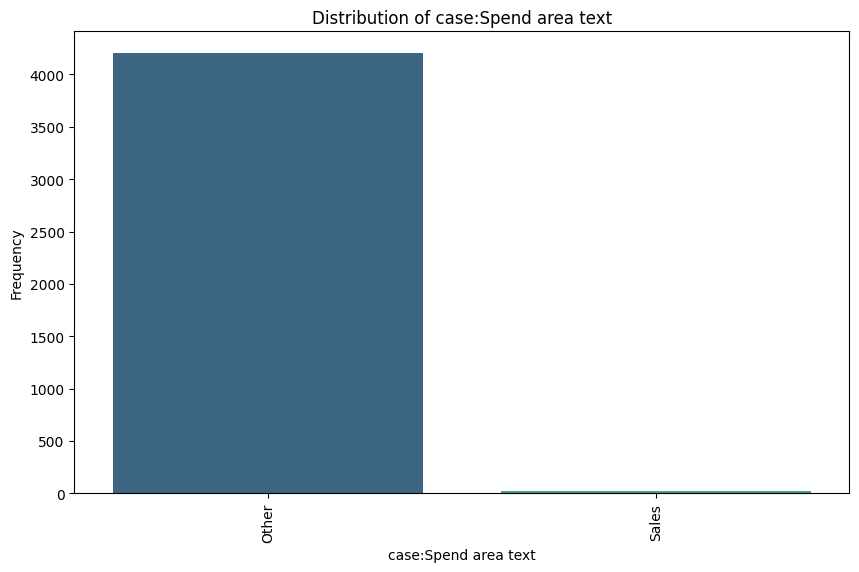

In [32]:
plot_attribute_distribution(log1, 'case:Spend area text')

C:\Users\jsala\AppData\Local\Temp\ipykernel_7424\3747086856.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")


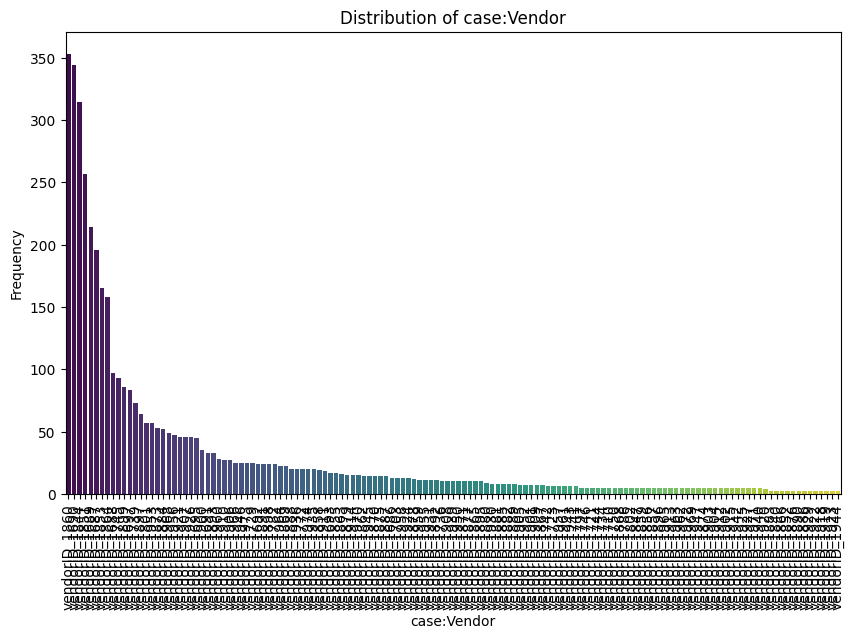

In [33]:
plot_attribute_distribution(log1, 'case:Vendor')

C:\Users\jsala\AppData\Local\Temp\ipykernel_7424\3747086856.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")


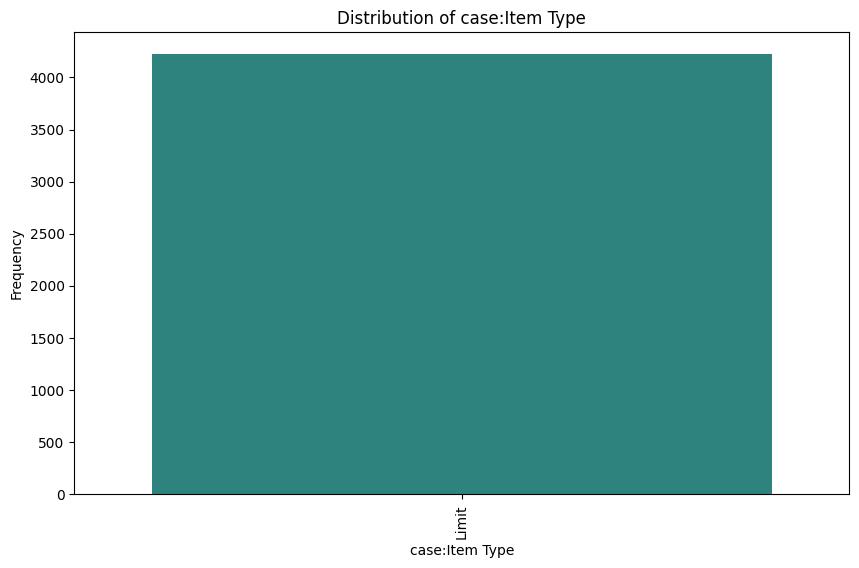

In [34]:
plot_attribute_distribution(log1, 'case:Item Type')

# 3-way match invoice before (PO)

In [36]:
# Load data 

log1_df = pm4py.read_xes("./3_waymatch_invoicebeforeGR_StandardPO.xes") # <class 'pandas.core.frame.DataFrame'>
log1 = pm4py.convert_to_event_log(log1_df) # convert it to a pm4py event log object

parsing log, completed traces :: 100%|██████████| 178600/178600 [00:44<00:00, 3980.17it/s]


C:\Users\jsala\AppData\Local\Temp\ipykernel_7424\3747086856.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")


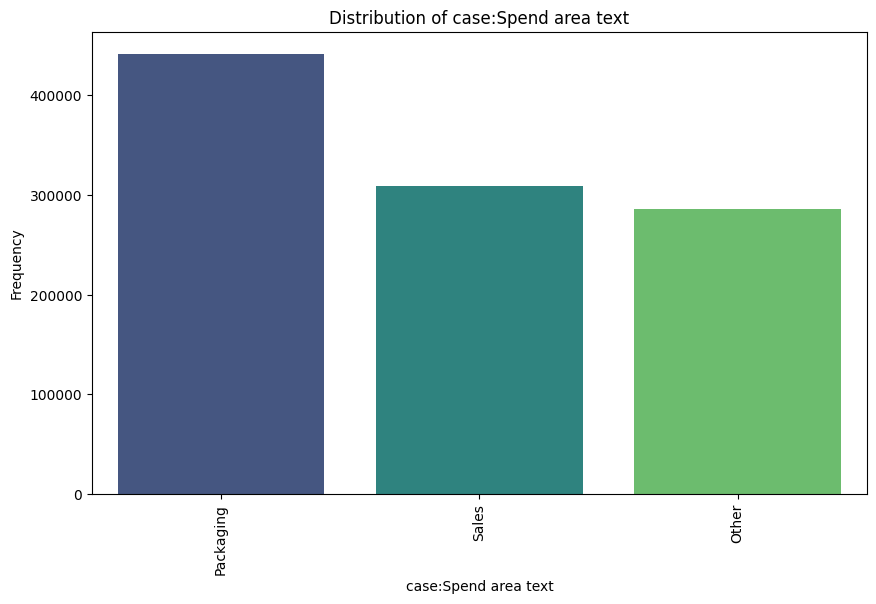

In [37]:
# Plot attribute "spend area text"

plot_attribute_distribution(log1, 'case:Spend area text')

C:\Users\jsala\AppData\Local\Temp\ipykernel_7424\2835487107.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  log1_df['year_month'] = log1_df['time:timestamp'].dt.to_period('M')


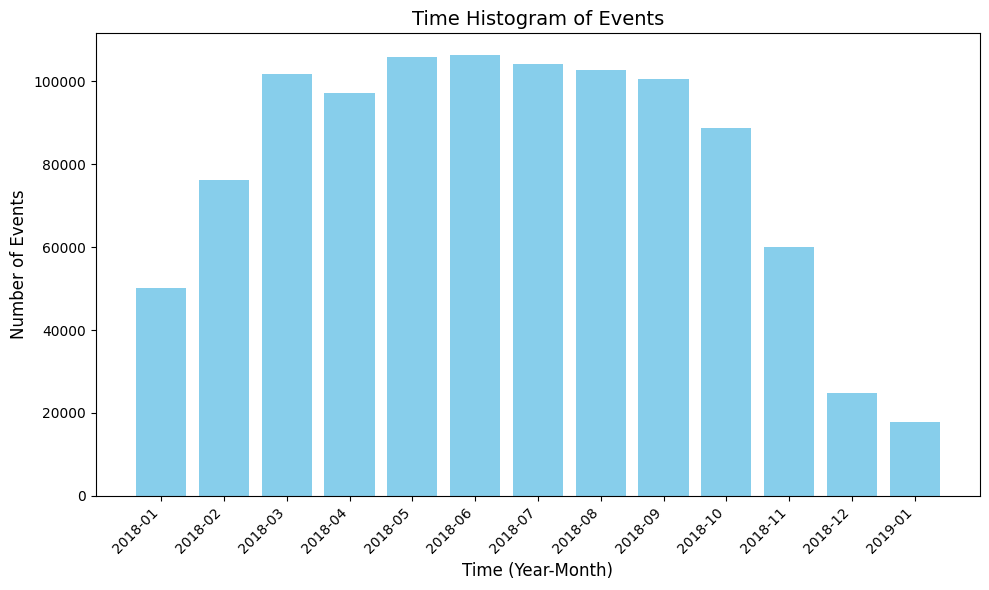

In [38]:
import matplotlib.pyplot as plt

log1_df['year_month'] = log1_df['time:timestamp'].dt.to_period('M')
time_counts = log1_df['year_month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(time_counts.index.astype(str), time_counts.values, color='skyblue')
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Time Histogram of Events', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Things we could analyze

**Focusing on 3_waymatch_invoicebeforeGR and 3_waymatch_invoiceafterGR (and remeber that we are just focusing on document type Standard PO)**

### 1) Explore time from 'Remove Payment Block' and 'Clear Invoice'


In [39]:
#### Loading data 3-way before

# Load event log (3_waymatch_invoicebeforeGR_StandardPO_Sales)
before_sales_df = pm4py.read_xes("data_to_analyze/3_waymatch_invoicebeforeGR_StandardPO_Sales.xes") # <class 'pandas.core.frame.DataFrame'>
before_sales_log = pm4py.convert_to_event_log(before_sales_df) # convert it to a pm4py event log object

# Load event log (3_waymatch_invoicebeforeGR_StandardPO_Packaging)
before_packaging_df = pm4py.read_xes("data_to_analyze/3_waymatch_invoicebeforeGR_StandardPO_Packaging.xes") 
before_packaging_log = pm4py.convert_to_event_log(before_packaging_df) 

# Load event log (3_waymatch_invoicebeforeGR_StandardPO_Other)
before_other_df = pm4py.read_xes("data_to_analyze/3_waymatch_invoicebeforeGR_StandardPO_Other.xes") 
before_other_log = pm4py.convert_to_event_log(before_other_df) 

#### Loading data 3-way after

# Load event log (3_waymatch_invoicebeforeGR_StandardPO_Sales)
after_sales_df = pm4py.read_xes("data_to_analyze/3_waymatch_invoiceafterGR_StandardPO_Sales.xes") # <class 'pandas.core.frame.DataFrame'>
after_sales_log = pm4py.convert_to_event_log(after_sales_df) # convert it to a pm4py event log object

# Load event log (3_waymatch_invoicebeforeGR_StandardPO_Packaging)
after_packaging_df = pm4py.read_xes("data_to_analyze/3_waymatch_invoiceafterGR_StandardPO_Packaging.xes") 
after_packaging_log = pm4py.convert_to_event_log(after_packaging_df) 

# Load event log (3_waymatch_invoicebeforeGR_StandardPO_Other)
after_other_df = pm4py.read_xes("data_to_analyze/3_waymatch_invoiceafterGR_StandardPO_Other.xes") 
after_other_log = pm4py.convert_to_event_log(after_other_df) 



parsing log, completed traces :: 100%|██████████| 3107/3107 [00:02<00:00, 1371.31it/s]


In [40]:
# Calculate time difference between two given subsequent activities 

def calculate_time_differences(event_log, activity1, activity2):
    time_differences = []

    for trace in event_log:
        for i in range(len(trace) - 1):
            if trace[i]['concept:name'] == activity1 and trace[i + 1]['concept:name'] == activity2:
                time_diff = trace[i + 1]['time:timestamp'] - trace[i]['time:timestamp']
                time_differences.append(time_diff.total_seconds() / 86400)

    time_diff_df = pd.DataFrame({'time_difference': time_differences})
    return time_diff_df

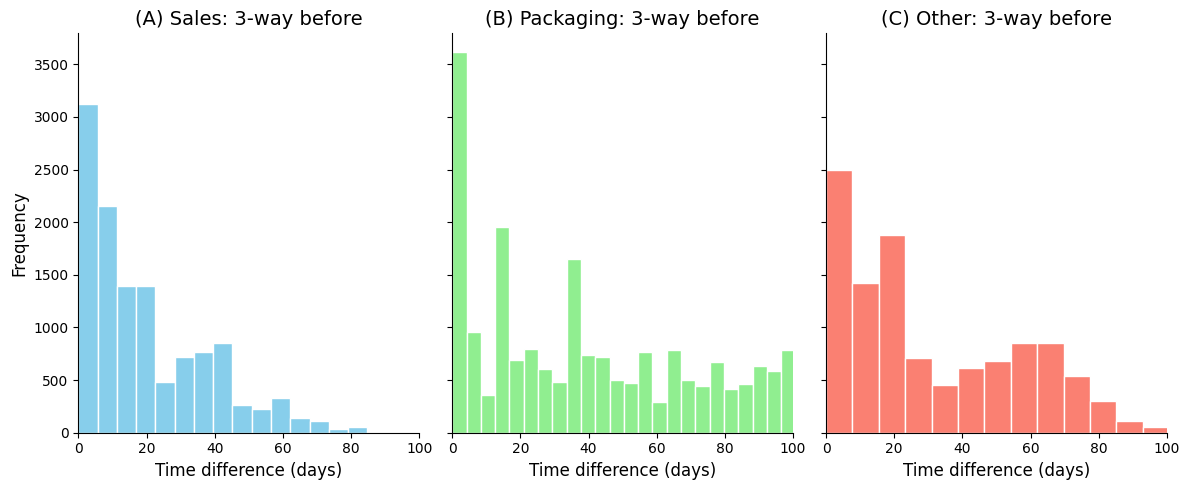

In [41]:
# Histograms of the time difference of Item Category = 3-way before

# Time difference between Remove Payment Block and Clear Invoice
t_diff_before_sales = calculate_time_differences(before_sales_log, 'Remove Payment Block', 'Clear Invoice')
t_diff_before_packaging = calculate_time_differences(before_packaging_log, 'Remove Payment Block', 'Clear Invoice')
t_diff_before_other = calculate_time_differences(before_other_log, 'Remove Payment Block', 'Clear Invoice')

# Plot (put the 3 plots together)
common_xlim = (0,100)

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

axes[0].hist(t_diff_before_sales['time_difference'], bins=30, color='skyblue', edgecolor='white')
axes[0].set_xlim(common_xlim)
axes[0].set_xlabel('Time difference (days)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('(A) Sales: 3-way before', fontsize=14)
axes[0].spines['top'].set_visible(False)  
axes[0].spines['right'].set_visible(False)  
axes[0].spines['left'].set_visible(True)  
axes[0].spines['bottom'].set_visible(True) 

axes[1].hist(t_diff_before_packaging['time_difference'], bins=30, color='lightgreen', edgecolor='white')
axes[1].set_xlim(common_xlim)
axes[1].set_xlabel('Time difference (days)', fontsize=12)
axes[1].set_title('(B) Packaging: 3-way before', fontsize=14)
axes[1].spines['top'].set_visible(False)  
axes[1].spines['right'].set_visible(False)  
axes[1].spines['left'].set_visible(True)  
axes[1].spines['bottom'].set_visible(True) 

axes[2].hist(t_diff_before_other['time_difference'], bins=30, color='salmon', edgecolor='white')
axes[2].set_xlim(common_xlim)
axes[2].set_xlabel('Time difference (days)', fontsize=12)
axes[2].set_title('(C) Other: 3-way before', fontsize=14)
axes[2].spines['top'].set_visible(False)  
axes[2].spines['right'].set_visible(False)  
axes[2].spines['left'].set_visible(True)  
axes[2].spines['bottom'].set_visible(True) 

plt.tight_layout()
plt.savefig("histograms_time_before.png", dpi=300, bbox_inches='tight', format='png')
plt.show()

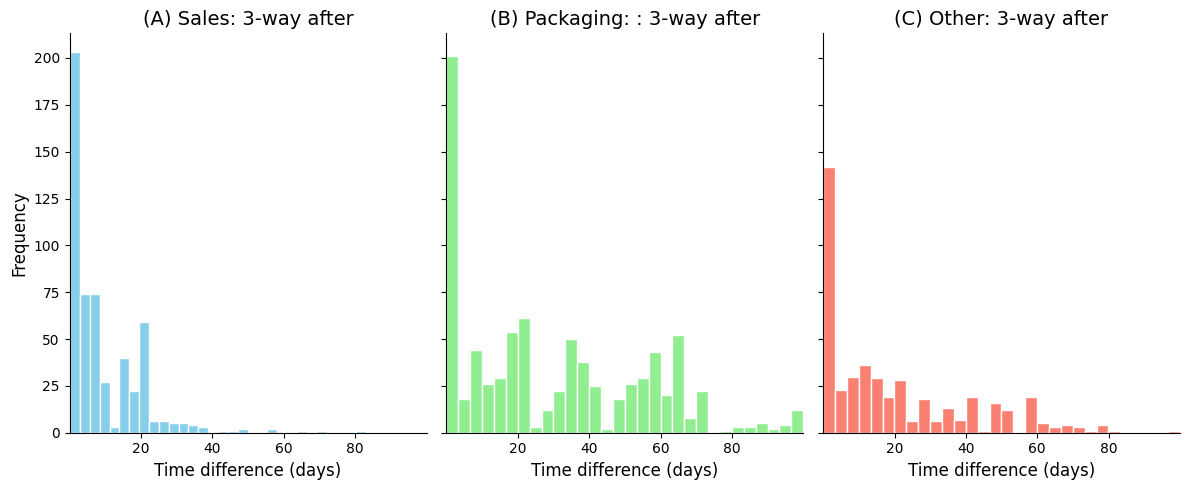

In [42]:
# Histograms of the time difference of Item Category = 3-way after

# Time difference between Remove Payment Block and Clear Invoice
t_diff_before_sales = calculate_time_differences(after_sales_log, 'Remove Payment Block', 'Clear Invoice')
t_diff_before_packaging = calculate_time_differences(after_packaging_log, 'Remove Payment Block', 'Clear Invoice')
t_diff_before_other = calculate_time_differences(after_other_log, 'Remove Payment Block', 'Clear Invoice')

# Plot (put the 3 plots together)
common_xlim = (min(t_diff_before_sales['time_difference'].min(), 
                   t_diff_before_packaging['time_difference'].min(), 
                   t_diff_before_other['time_difference'].min()), 
               max(t_diff_before_sales['time_difference'].max(), 
                   t_diff_before_packaging['time_difference'].max(), 
                   t_diff_before_other['time_difference'].max()))

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

axes[0].hist(t_diff_before_sales['time_difference'], bins=30, color='skyblue', edgecolor='white')
axes[0].set_xlim(common_xlim)
axes[0].set_xlabel('Time difference (days)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('(A) Sales: 3-way after', fontsize=14)
axes[0].spines['top'].set_visible(False)  
axes[0].spines['right'].set_visible(False)  
axes[0].spines['left'].set_visible(True)  
axes[0].spines['bottom'].set_visible(True) 

axes[1].hist(t_diff_before_packaging['time_difference'], bins=30, color='lightgreen', edgecolor='white')
axes[1].set_xlim(common_xlim)
axes[1].set_xlabel('Time difference (days)', fontsize=12)
axes[1].set_title('(B) Packaging: : 3-way after', fontsize=14)
axes[1].spines['top'].set_visible(False)  
axes[1].spines['right'].set_visible(False)  
axes[1].spines['left'].set_visible(True)  
axes[1].spines['bottom'].set_visible(True) 

axes[2].hist(t_diff_before_other['time_difference'], bins=30, color='salmon', edgecolor='white')
axes[2].set_xlim(common_xlim)
axes[2].set_xlabel('Time difference (days)', fontsize=12)
axes[2].set_title('(C) Other: 3-way after', fontsize=14)
axes[2].spines['top'].set_visible(False)  
axes[2].spines['right'].set_visible(False)  
axes[2].spines['left'].set_visible(True)  
axes[2].spines['bottom'].set_visible(True) 

plt.tight_layout()
plt.savefig("histograms_time_after.png", dpi=300, bbox_inches='tight', format='png')
plt.show()

### 2) Visualize some price distributions in the different spending areas

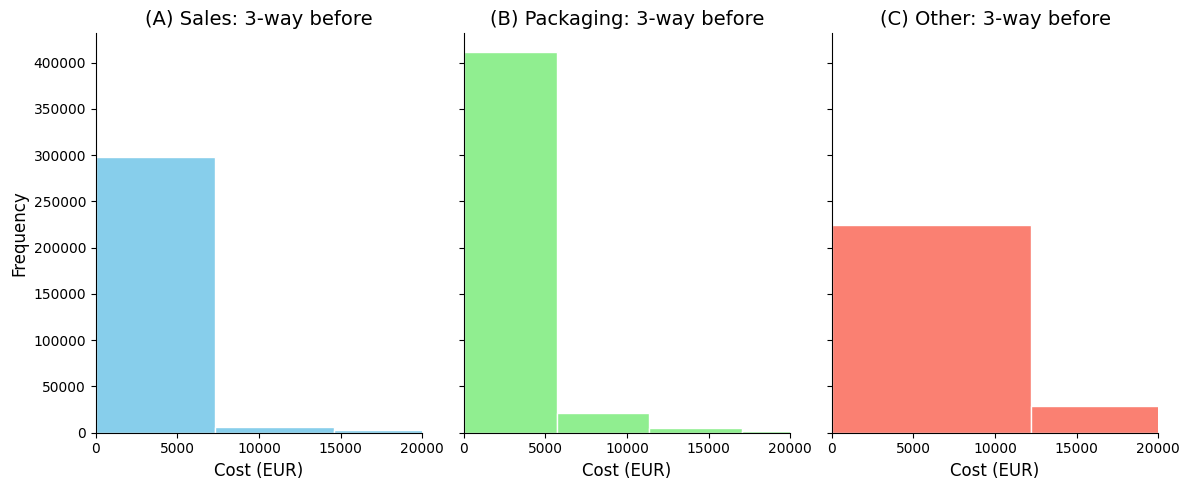

In [43]:
# Plot (put the 3 plots together)
common_xlim = (0,20000)
#common_xlim = common_xlim = (min(before_sales_df['Cumulative net worth (EUR)'].min(), before_packaging_df['Cumulative net worth (EUR)'].min(), before_other_df['Cumulative net worth (EUR)'].min()),  max(before_sales_df['Cumulative net worth (EUR)'].max(), before_packaging_df['Cumulative net worth (EUR)'].max(), before_other_df['Cumulative net worth (EUR)'].max()))

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

axes[0].hist(before_sales_df['Cumulative net worth (EUR)'], bins=30, color='skyblue', edgecolor='white')
axes[0].set_xlim(common_xlim)
axes[0].set_xlabel('Cost (EUR)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('(A) Sales: 3-way before', fontsize=14)
axes[0].spines['top'].set_visible(False)  
axes[0].spines['right'].set_visible(False)  
axes[0].spines['left'].set_visible(True)  
axes[0].spines['bottom'].set_visible(True) 

axes[1].hist(before_packaging_df['Cumulative net worth (EUR)'], bins=30, color='lightgreen', edgecolor='white')
axes[1].set_xlim(common_xlim)
axes[1].set_xlabel('Cost (EUR)', fontsize=12)
axes[1].set_title('(B) Packaging: 3-way before', fontsize=14)
axes[1].spines['top'].set_visible(False)  
axes[1].spines['right'].set_visible(False)  
axes[1].spines['left'].set_visible(True)  
axes[1].spines['bottom'].set_visible(True) 

axes[2].hist(before_other_df['Cumulative net worth (EUR)'], bins=30, color='salmon', edgecolor='white')
axes[2].set_xlim(common_xlim)
axes[2].set_xlabel('Cost (EUR)', fontsize=12)
axes[2].set_title('(C) Other: 3-way before', fontsize=14)
axes[2].spines['top'].set_visible(False)  
axes[2].spines['right'].set_visible(False)  
axes[2].spines['left'].set_visible(True)  
axes[2].spines['bottom'].set_visible(True) 

plt.tight_layout()
plt.savefig("histograms_price_before.png", dpi=300, bbox_inches='tight', format='png')
plt.show()

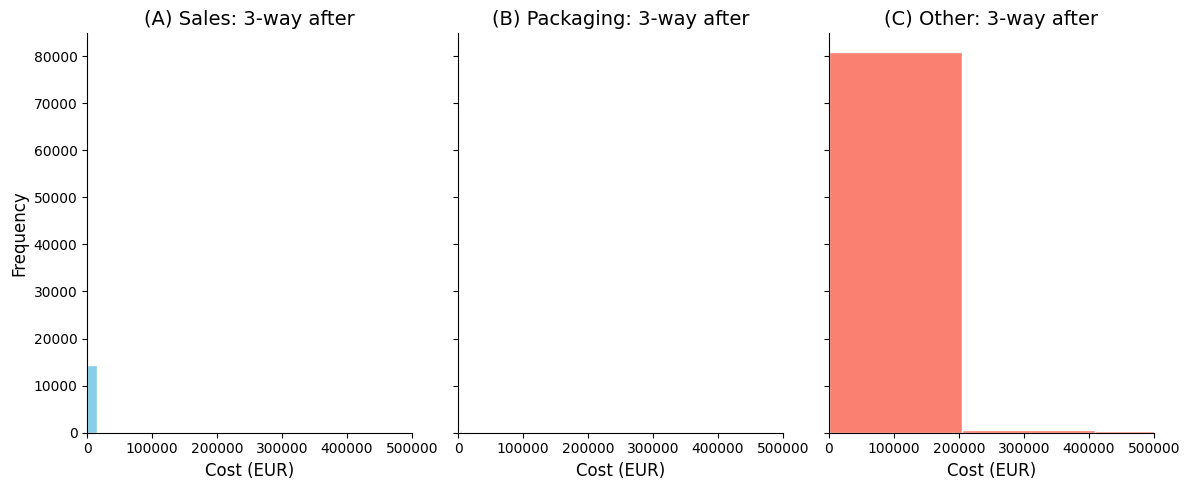

In [44]:
# Plot (put the 3 plots together)
common_xlim = (0,500000)
#common_xlim = common_xlim = (min(after_sales_df['Cumulative net worth (EUR)'].min(), after_packaging_df['Cumulative net worth (EUR)'].min(), after_other_df['Cumulative net worth (EUR)'].min()),  max(after_sales_df['Cumulative net worth (EUR)'].max(), after_packaging_df['Cumulative net worth (EUR)'].max(), after_other_df['Cumulative net worth (EUR)'].max()))

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

axes[0].hist(after_sales_df['Cumulative net worth (EUR)'], bins=30, color='skyblue', edgecolor='white')
axes[0].set_xlim(common_xlim)
axes[0].set_xlabel('Cost (EUR)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('(A) Sales: 3-way after', fontsize=14)
axes[0].spines['top'].set_visible(False)  
axes[0].spines['right'].set_visible(False)  
axes[0].spines['left'].set_visible(True)  
axes[0].spines['bottom'].set_visible(True) 

axes[1].hist(after_packaging_df['Cumulative net worth (EUR)'], bins=30, color='lightgreen', edgecolor='white')
axes[1].set_xlim(common_xlim)
axes[1].set_xlabel('Cost (EUR)', fontsize=12)
axes[1].set_title('(B) Packaging: 3-way after', fontsize=14)
axes[1].spines['top'].set_visible(False)  
axes[1].spines['right'].set_visible(False)  
axes[1].spines['left'].set_visible(True)  
axes[1].spines['bottom'].set_visible(True) 

axes[2].hist(after_other_df['Cumulative net worth (EUR)'], bins=30, color='salmon', edgecolor='white')
axes[2].set_xlim(common_xlim)
axes[2].set_xlabel('Cost (EUR)', fontsize=12)
axes[2].set_title('(C) Other: 3-way after', fontsize=14)
axes[2].spines['top'].set_visible(False)  
axes[2].spines['right'].set_visible(False)  
axes[2].spines['left'].set_visible(True)  
axes[2].spines['bottom'].set_visible(True) 

plt.tight_layout()
plt.savefig("histograms_price_after.png", dpi=300, bbox_inches='tight', format='png')
plt.show()

In [68]:
for trace in after_sales_log:
    print(len(trace))

5
6
5
7
5
8
5
5
5
5
5
5
6
9
5
6
5
5
5
9
6
5
5
6
5
7
5
5
5
9
6
7
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
5
5
5
7
5
5
5
6
6
7
7
7
10
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
8
6
10
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
11
5
5
6
6
8
11
6
6
6
6
6
6
5
5
5
5
5
6
10
6
6
5
5
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
2
2
6
5
5
5
6
5
6
7
5
5
9
7
10
10
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
12
7
9
7
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
17
5
6
6
6
5
5
5
5
6
5
6
6
6
12
13
6
6
5
13
5
5
5
5
5
6
2
7
6
5
5
5
6
7
6
6
5
5
5
5
5
5
5
5
5
6
6
7
5
6
31
6
5
5
5
5
6
5
6
6
5
6
6
6
7
5
5
5
5
5
5
6
6
6
13
5
5
5
5
5
10
7
7
7
7
7
6
7
7
6
5
9
5
5
5
5
6
5
6
6
20
5
5
5
5
6
6
5
5
5
5
6
7
7
6
7
9
13
9
5
6
5
5
5
5
5
5
6
7
5
5
5
5
7
7
14
14
6
5
5
5
6
5
6
6
5
10
6
5
5
6
5
5
5
5
6
6
6
7
7
7
13
10
5
5
5
5
6
5
5
5
6
12
7
7
5
5
6
6
7
7
5
6
6
6
6
6
5
5
5
5
9
5
5
7
6
5
19
5
5
5
5
6
6
6
2
2
2
5
5
5
6
6
6
7
6
6
6
6
7
7
5
5
5
6
6
6
8
5
5
5
5
6
6
6
6
6
6
5
5
5
5
5
5
7
9
6
14
9
5
6
5
7
5
5
5
5
5
5
6
6
5
5
5
5
5
6
6
6
5
5
5
5
5
5
5
5
8
5
5
5
5
5
5
5
5
6
9
7
13
6
5
5
5
5
5


In [79]:
def get_number_of_activities(event_log):
    num_activities = []

    for trace in event_log:
        num_activities.append(len(trace))

    num_activities_df = pd.DataFrame({'num_activities': num_activities})
    return num_activities_df



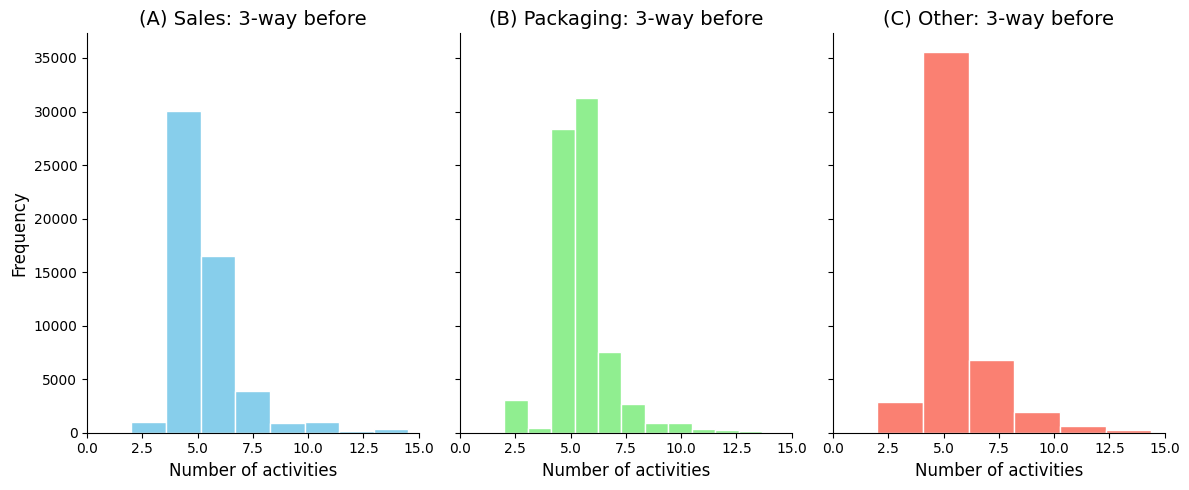

In [78]:
# 3) Activities distribution in the differentt categories/spend area

# Plot (put the 3 plots together)
common_xlim = (0,15)
#common_xlim = common_xlim = (min(before_sales_df['Cumulative net worth (EUR)'].min(), before_packaging_df['Cumulative net worth (EUR)'].min(), before_other_df['Cumulative net worth (EUR)'].min()),  max(before_sales_df['Cumulative net worth (EUR)'].max(), before_packaging_df['Cumulative net worth (EUR)'].max(), before_other_df['Cumulative net worth (EUR)'].max()))

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

axes[0].hist(get_number_of_activities(before_sales_log), bins=30, color='skyblue', edgecolor='white')
axes[0].set_xlim(common_xlim)
axes[0].set_xlabel('Number of activities', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('(A) Sales: 3-way before', fontsize=14)
axes[0].spines['top'].set_visible(False)  
axes[0].spines['right'].set_visible(False)  
axes[0].spines['left'].set_visible(True)  
axes[0].spines['bottom'].set_visible(True) 

axes[1].hist(get_number_of_activities(before_packaging_log), bins=30, color='lightgreen', edgecolor='white')
axes[1].set_xlim(common_xlim)
axes[1].set_xlabel('Number of activities', fontsize=12)
axes[1].set_title('(B) Packaging: 3-way before', fontsize=14)
axes[1].spines['top'].set_visible(False)  
axes[1].spines['right'].set_visible(False)  
axes[1].spines['left'].set_visible(True)  
axes[1].spines['bottom'].set_visible(True) 

axes[2].hist(get_number_of_activities(before_other_log), bins=30, color='salmon', edgecolor='white')
axes[2].set_xlim(common_xlim)
axes[2].set_xlabel('Number of activities', fontsize=12)
axes[2].set_title('(C) Other: 3-way before', fontsize=14)
axes[2].spines['top'].set_visible(False)  
axes[2].spines['right'].set_visible(False)  
axes[2].spines['left'].set_visible(True)  
axes[2].spines['bottom'].set_visible(True) 

plt.tight_layout()
plt.savefig("histograms_price_before.png", dpi=300, bbox_inches='tight', format='png')
plt.show()

In [ ]:
# 4) Analyze all the steps again without considering the activities that happen with a low freq

In [ ]:
# 5) ...